In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torchvision.models import resnet50
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Define device variable for cuda, mps or cpu

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using MPS')
else :
    device = torch.device('cpu')
    print('Using CPU')


Using MPS


In [4]:
#We want to use a resnet50 from torchvision to have the embedding of an image, use a pretrained resnet and remove the last layer

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        self.resnet.eval()
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.resnet(x)

In [5]:
# Do a simple KNN for an image embedding

class KNN(nn.Module):
    def __init__(self, k):
        super(KNN, self).__init__()
        self.k = k
    def forward(self, dataset, x):
        x = x.flatten(1)
        dataset = dataset.flatten(2).flatten(1)
        distances = torch.cdist(x, dataset)

        # Get indices of k nearest neighbors for each test point
        distances_k, indices = torch.topk(distances, self.k, largest=False)
        return distances.squeeze(0), distances_k.squeeze(0), indices.squeeze(0)


In [6]:
class KNN_tabulaire(nn.Module):
    def __init__(self, k):
        super(KNN_tabulaire, self).__init__()
        self.k = k
    def forward(self, dataset, x):
        distances = torch.cdist(x, dataset)

        # Get indices of k nearest neighbors for each test point
        distances_k, indices = torch.topk(distances, self.k, largest=False)
        return distances, distances_k, indices

In [7]:
#Create the resnet model
resnet = ResNet().to(device)
resnet.eval()


Using cache found in /Users/jskaf/.cache/torch/hub/pytorch_vision_v0.6.0
/Users/jskaf/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jskaf/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 25

In [8]:
from dataset import myDataset
from torch.utils.data import DataLoader

#Create the dataset

get_preprocessed_image = True
my_path_hm = os.path.join(os.getcwd(), 'data/h&mdataset/images/')
my_path_fash = os.path.join(os.getcwd(), 'data/fashion-dataset/images/')

dataset = myDataset(my_path_hm, my_path_fash, get_preprocessed_image, 'hm')
dataset_loader = DataLoader(dataset, batch_size=512, shuffle=False, num_workers=8,pin_memory=True)

input, idx = dataset[0].unsqueeze(0).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


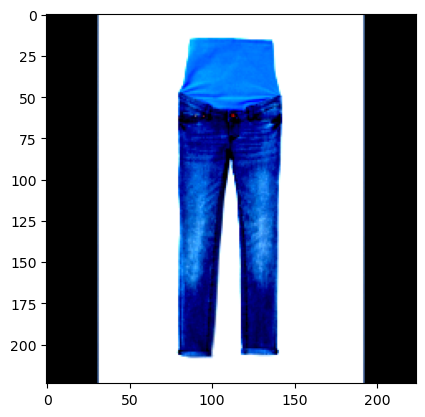

In [9]:
#plot the image input 

plt.imshow(input.squeeze(0).permute(1, 2, 0).cpu().numpy())

In [10]:
#Find the k nearest neighbors of an image in the dataset by using the KNN model and the resnet model by batches to avoid memory issues (Version 1 pas ouf)


distances_img = torch.tensor([]).to(device)
k_distances_img = torch.tensor([]).to(device)
indices_img = torch.tensor([]).to(device)
model = KNN(6).to(device)

for batch in tqdm(dataset_loader):
    batch = batch.to(device)
    imgs, idx = batch
    embeddings = resnet(imgs)
    input_embedding = resnet(input)
    distances_temp, distances_k_temp, indices_temp = model(embeddings, input_embedding)
    distances_img = torch.cat((distances_img, distances_temp))
    k_distances_img = torch.cat((k_distances_img, distances_k_temp))
    indices_img = torch.cat((indices_img, indices_temp))

#save k_distances_img, indices_img

torch.save(k_distances_img, 'models/KNNbrutforce/k_distances_img.pt')
torch.save(indices_img, 'models/KNNbrutforce/indices_img.pt')


  0%|          | 0/206 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [12]:
k_distances_img = torch.load('k_distances_img.pt')
indices_img = torch.load('indices_img.pt')

In [13]:
k_distances_img_vf, indices_img_vf = torch.topk(k_distances_img, 6, largest=False)
indices_img_vf = indices_img[indices_img_vf]

In [14]:
indices_img_vf

tensor([  0., 255., 464., 446., 313., 193.], device='mps:0')

In [15]:
df = pd.read_csv('data/h&mdataset/articles.csv')
df.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [16]:
df = df.drop(columns=['article_id','prod_name','product_code','product_type_no','department_no', 'index_code', 	
       'product_type_name', 'product_group_name',
       'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name', 'detail_desc'])

In [17]:
df.head()

,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,index_group_no,section_no,garment_group_no
0,1010016,9,4,5,1,16,1002
1,1010016,10,3,9,1,16,1002
2,1010017,11,1,9,1,16,1002
3,1010016,9,4,5,1,61,1017
4,1010016,10,3,9,1,61,1017


In [18]:
input_tab = df.iloc[0]

#delete the first row

df = df.drop(0)

In [19]:
#StandardScale each column of the dataframe

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)


In [20]:
df_scaled.tail()

,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,index_group_no,section_no,garment_group_no
105536,0.022260,-0.827245,0.507613,-0.522251,-0.039408,-0.716445,1.569109
105537,0.022349,-0.827245,0.507613,-0.522251,-0.498838,-1.748261,-0.807962
105538,0.022349,-0.827245,0.507613,-0.522251,-0.498838,-1.060383,-0.807962
105539,0.022349,-0.827245,0.507613,-0.522251,-0.269123,0.401356,1.271975
105540,0.022349,-0.756035,-1.410745,0.221697,-0.498838,-1.060383,-0.807962


In [21]:
df_scaled.shape

(105541, 7)

In [22]:
input_tab_scaled = scaler.transform([input_tab])

/Users/jskaf/miniconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [23]:
dataset_tab = df_scaled.to_numpy()

In [24]:
model = KNN_tabulaire(5).to(device)

input_tab_scaled = torch.tensor(input_tab_scaled, dtype=torch.float32).to(device)
dataset_tab = torch.tensor(dataset_tab, dtype=torch.float32).to(device)

distances_tab, distances_k_tab, indices_tab = model(dataset_tab, input_tab_scaled)

In [25]:
indices_tab = torch.tensor(indices_tab,dtype = torch.int64).squeeze(0)

/var/folders/62/6pb5kjf139gccp8_mvcxrc7w0000gn/T/ipykernel_8461/2917877256.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices_tab = torch.tensor(indices_tab,dtype = torch.int64).squeeze(0)


In [26]:
indices_img_1 = torch.tensor(indices_img_vf,dtype = torch.int64)

/var/folders/62/6pb5kjf139gccp8_mvcxrc7w0000gn/T/ipykernel_8461/454788638.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices_img_1 = torch.tensor(indices_img_vf,dtype = torch.int64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


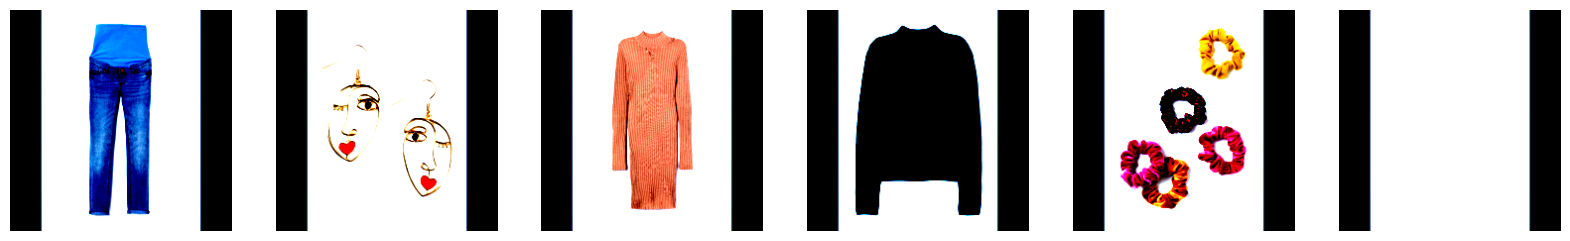

In [27]:
# print the images of the k nearest neighbors

fig, ax = plt.subplots(1, 6, figsize=(20, 20))
for i in range(6):
    img = dataset_loader.dataset[indices_img_1[i]].permute(1, 2, 0).cpu().numpy()
    ax[i].imshow(img)
    ax[i].axis('off')

Pourtant

/var/folders/62/6pb5kjf139gccp8_mvcxrc7w0000gn/T/ipykernel_8461/1907340141.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices_img_2 = torch.tensor(indices_img,dtype = torch.int64)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

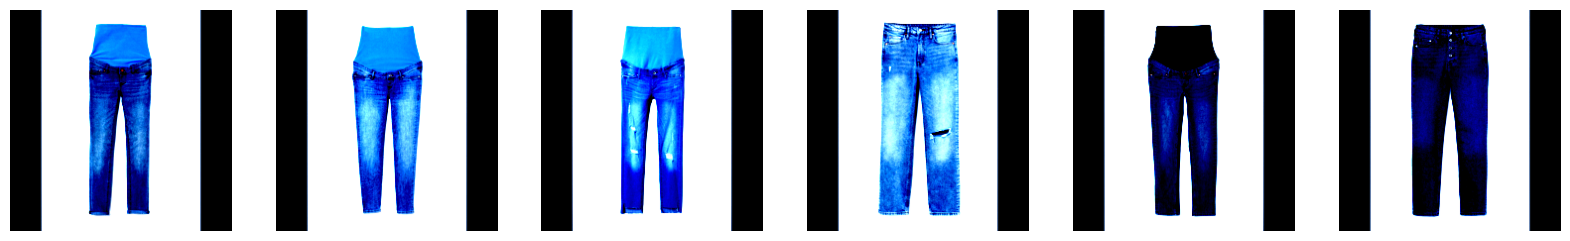

In [28]:
indices_img_2 = torch.tensor(indices_img,dtype = torch.int64)
fig, ax = plt.subplots(1, 6, figsize=(20, 20))
for i in range(6):
    img = dataset_loader.dataset[indices_img_2[i]][0].permute(1, 2, 0).cpu().numpy()
    ax[i].imshow(img)
    ax[i].axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


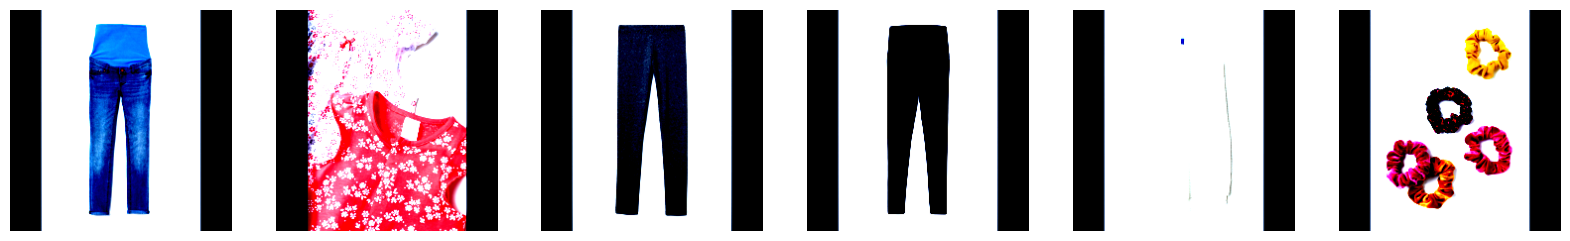

In [29]:
#idem for index tab
#checker si la correspondance indice image et indice tabulaire est bonne

fig, ax = plt.subplots(1, 6, figsize=(20, 20))
ax[0].imshow(dataset_loader.dataset[0].permute(1, 2, 0).cpu().numpy())
ax[0].axis('off')
for i in range(1,6):
    img = dataset_loader.dataset[indices_tab[i-1]][0].permute(1, 2, 0).cpu().numpy()
    ax[i].imshow(img)
    ax[i].axis('off')